In [1]:
import numpy as np 
import pandas as pd 
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
downloaded = drive.CreateFile({'id':"10frChX6he0sqLY1j7V1iWgBFFzaje8TL"})   # replace the id with id of file you want to access
downloaded.GetContentFile('train.zip') 

In [5]:
try:
  os.mkdir('Data')
  os.mkdir('Data/CatsDogs')
  os.mkdir('Data/CatsDogs/trn')
  os.mkdir('Data/CatsDogs/trn/dogs')
  os.mkdir('Data/CatsDogs/trn/cats')
  os.mkdir('Data/CatsDogs/val')
  os.mkdir('Data/CatsDogs/val/dogs')
  os.mkdir('Data/CatsDogs/val/cats')
  os.mkdir('Data/CatsDogs/tst')
  os.mkdir('Data/CatsDogs/tst/dogs')
  os.mkdir('Data/CatsDogs/tst/cats')
except OSError:
  pass

train_dir = 'Data/CatsDogs/trn'
val_dir = 'Data/CatsDogs/val'
test_dir = 'Data/CatsDogs/tst'

!unzip train.zip -d Data/CatsDogs > /dev/null

In [6]:
%matplotlib inline
unpack_dir = 'Data/CatsDogs/train'
tr_imgs = [f'{i}' for i in os.listdir(unpack_dir)]

np.random.shuffle(tr_imgs)

In [7]:
trainratio = 0.75
valratio = 0.1

train = int(len(tr_imgs) * trainratio)
val = int(len(tr_imgs) * valratio)

In [8]:
def move_images(imgs, firstimage, lastimage, source, destination):

  for fnam in imgs[firstimage:lastimage]:
    srcfile = source + '/' + fnam
    if 'dog' in fnam:
      destfile = destination + '/dogs/' + fnam
    else:
      destfile = destination + '/cats/' + fnam
    os.replace(srcfile, destfile)    

move_images(tr_imgs, 0, train, unpack_dir, train_dir)
move_images(tr_imgs, train, train + val, unpack_dir, val_dir)
move_images(tr_imgs, train + val, len(tr_imgs), unpack_dir, test_dir)

In [14]:
print('Dogs in training set ', len(os.listdir(train_dir + '/dogs')))
print('Cats in training set ', len(os.listdir(train_dir + '/cats')))
print('Dogs in validation set ', len(os.listdir(val_dir + '/dogs')))
print('Cats in validation set ', len(os.listdir(val_dir + '/cats')))
print('Dogs in test set ', len(os.listdir(test_dir + '/dogs')))
print('Cats in test set ', len(os.listdir(test_dir + '/cats')))



Dogs in training set  9351
Cats in training set  9399
Dogs in validation set  1240
Cats in validation set  1260
Dogs in test set  1909
Cats in test set  1841


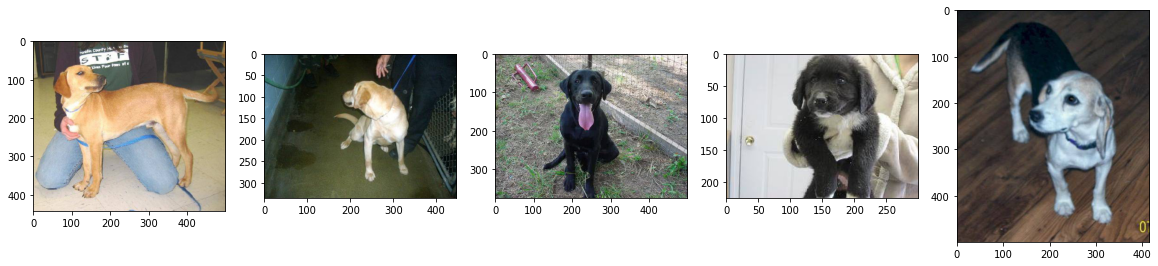

In [17]:
traindogs = [f'{train_dir}/dogs/{i}' for i in os.listdir(train_dir + '/dogs')]
plt.figure(figsize=(20, 10))
cols = 5
for i in range(cols):
    plt.subplot(int(5 / cols+1), cols, i+1)
    plt.imshow(mpimg.imread(traindogs[i]))

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

batch_size = 32

trn_data = ImageDataGenerator(rescale=1/255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True)
valtst_data = ImageDataGenerator(rescale=1/255)

trn_gen = trn_data.flow_from_directory(train_dir, batch_size=batch_size, class_mode='binary', target_size=(150,150))      
val_gen = valtst_data.flow_from_directory(val_dir, batch_size=batch_size, class_mode='binary', target_size=(150,150))   
tst_gen = valtst_data.flow_from_directory(test_dir, batch_size=batch_size, class_mode='binary', target_size=(150,150), shuffle=False) 

Found 18750 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras import layers, models

def gen_model():
    base=InceptionResNetV2(weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3))
    model = models.Sequential()
    model.add(base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))
    base.trainable = False
    return model


In [ ]:
model = gen_model()
model.summary()

219055592/219055592 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 3, 3, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 13824)             0         
                                                                 
 dense (Dense)               (None, 256)               3539200   
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 57,876,450
Trainable params: 3,539,714
Non-trainable params: 54,336,736
_________________________________________________________________


In [ ]:
from tensorflow.keras import optimizers

epochs = 1

model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizers.Adam(learning_rate=2e-5),
                metrics=['acc'])
hist = model.fit(trn_gen, validation_data=val_gen,
                epochs=epochs)    

586/586 [==============================] - 188s 290ms/step - loss: 0.2013 - acc: 0.9247 - val_loss: 0.0958 - val_acc: 0.9664


<Figure size 432x288 with 0 Axes>

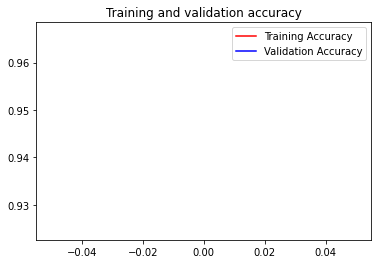

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(range(epochs), hist.history['acc'], 'r', label="Training Accuracy")
plt.plot(range(epochs), hist.history['val_acc'], 'b', label="Validation Accuracy")
plt.legend()
plt.title('Training and validation accuracy')
plt.figure()

In [ ]:
pr_yclass = model.predict(tst_gen)
pr_y = np.argmax(pr_yclass, axis=1)
true_y = tst_gen.classes


118/118 [==============================] - 17s 120ms/step


In [ ]:
(pr_y==true_y).sum()/len(true_y)

0.9725333333333334

In [ ]:
tf.math.confusion_matrix(true_y, pr_y)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1783,   68],
       [  35, 1864]], dtype=int32)>